# Задание 5.1 - Word2Vec

В этом задании мы натренируем свои word vectors на очень небольшом датасете.
Мы будем использовать самую простую версию word2vec, без negative sampling и других оптимизаций.

Перед запуском нужно запустить скрипт `download_data.sh` чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA 

%matplotlib inline

In [30]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)
#     print(data.token_by_index.index(center_word))

# print(data.token_by_index[4])

Num tokens: 19538
rebirth ['interesting', 'parisian', 'stillborn']
obligatory ['exploitive', 'array', 'thrills']
culture ['ways', 'consume']
disgust ['anything', 'save', 'indifference']
, ['symbols', 'loss']


# Имплеменируем PyTorch-style Dataset для Word2Vec

Этот Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Напоминаем, что word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов.
Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [31]:
class Word2VecPlain(Dataset):
    '''
    PyTorch Dataset for plain Word2Vec.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_contexts=30000):
        '''
        Initializes Word2VecPlain, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_contexts - number of random contexts to use when generating a dataset
        '''
        self.data = data
        self.num_contexts = num_contexts
        self.num_tokens = data.num_tokens()
        self.pairs = []
    
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        for _ in range(self.num_contexts):
            center_word, other_words = self.data.get_random_context(5)
            
            for i in other_words:
                self.pairs.append((center_word, i))
#             index = data.token_by_index.index(center_word)
            
        
    def __len__(self):
        '''
        Returns total number of samples
        '''
        return len(self.pairs)
    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - torch.Tensor with one-hot representation of the input vector
        output_index - index of the target word (not torch.Tensor!)
        '''
        a, b = self.pairs[index]
        
        a_ = torch.zeros(self.data.num_tokens())
        a_[self.data.token_by_index.index(a)] = 1
        b_ = self.data.token_by_index.index(b)
        
        return a_, b_

dataset = Word2VecPlain(data, 10)
dataset.generate_dataset()
input_vector, target = dataset[3]
print(*dataset.pairs, sep='\n')
# a = dataset.data.index_by_token[input_vector.argmax().item()]
# a = input_vector.argmax().item()
# print(dataset.data.token_by_index[a])
print("Sample - input: %s, target: %s" % (input_vector, int(target))) # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()




('iditarod', 'lasts')
('iditarod', 'felt')
('broad', 'latest')
('broad', 'ambling')
('broad', 'about')
('broad', 'hate')
('characteristic', 'exhibits')
('characteristic', 'sensationalism')
('characteristic', 'salacious')
('characteristic', 'telenovela')
('give-a-damn', 'primer')
('give-a-damn', 'know-how')
('large', 'quick-cuts')
('large', 'very')
('large', 'shadows')
('large', 'wide-angle')
('drama\\/action', 'stays')
('drama\\/action', 'afloat')
('be', 'middle-america')
('be', 'diversions')
('rocket', 'scientist')
('rocket', 'mormon')
('insufferable', 'movie')
('insufferable', 'is')
('sound', 'costumes')
('sound', 'astounding')
('sound', 'given')
Sample - input: tensor([0., 0., 0.,  ..., 0., 0., 0.]), target: 5078


# Создаем модель и тренируем ее

In [45]:
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()

wordvec_dim = 10

nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model.type(torch.FloatTensor)

Sequential(
  (0): Linear(in_features=19538, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=19538, bias=False)
)

In [46]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    
#     print(nn_model[0].weight.T.shape, nn_model[1].weight.shape)
    return nn_model[0].weight.T.detach(), nn_model[1].weight.detach()

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [47]:
def train_model(model, dataset, train_loader, optimizer, scheduler, num_epochs):
    '''
    Trains plain word2vec using cross-entropy loss and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    
    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        dataset.generate_dataset() # Regenerate dataset every epoch
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x) 
            
            y_ = torch.argmax(prediction, dim=1)
            
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
#             _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(y_ == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        
        scheduler.step()
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        
        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **8.0**.

In [48]:
optimizer = optim.SGD(nn_model.parameters(), lr=5, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.2)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

# for x, y in train_loader:
#     a = nn_model(x)
#     b = torch.argmax(a, dim=1) #нужно брать индекс максимального
#     print(a.shape, y.shape)
#     break

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 10)

Epoch 0, Average loss: 9.820773, Train accuracy: 0.001863
Epoch 1, Average loss: 9.294214, Train accuracy: 0.007751
Epoch 2, Average loss: 8.882965, Train accuracy: 0.013591
Epoch 3, Average loss: 8.741757, Train accuracy: 0.015851
Epoch 4, Average loss: 8.130562, Train accuracy: 0.030890
Epoch 5, Average loss: 7.934873, Train accuracy: 0.035601
Epoch 6, Average loss: 7.868527, Train accuracy: 0.037797
Epoch 7, Average loss: 7.819263, Train accuracy: 0.039346
Epoch 8, Average loss: 7.636083, Train accuracy: 0.047628
Epoch 9, Average loss: 7.613891, Train accuracy: 0.048922


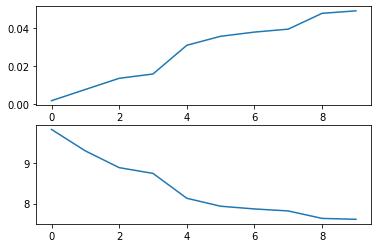

In [49]:
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

# Визуализируем вектора для разного вида слов до и после тренировки

В случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных) разделяются семантически.

Студенты - в качестве выполненного задания присылайте notebook с диаграммами!

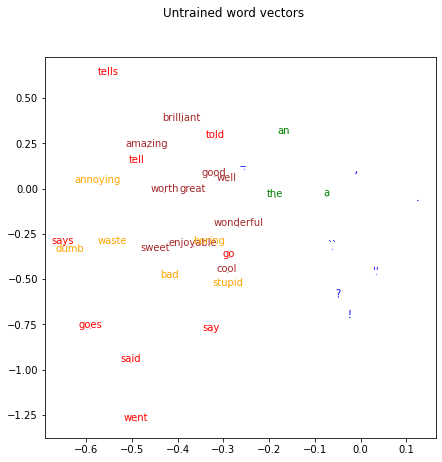

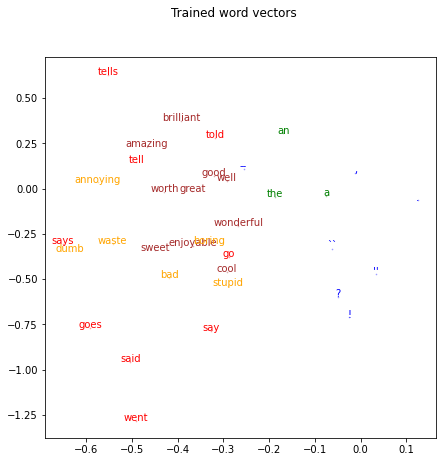

In [50]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors)

    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")